In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
import pandas as pd
from basic_rl_envi_for_dam_bidding_main.import_data_example import get_demand, get_gen, get_mcp, get_vre
from environment_kim import market_env
from actor_critic import ActorCriticAgent

In [160]:
start = pd.Timestamp(year=2023, month=1, day=1, tz="europe/brussels")
end = pd.Timestamp.now(tz="europe/brussels").floor('D') + pd.Timedelta(days=1)

In [161]:
df_demand = get_demand(start, end)
df_mcp = get_mcp(start, end)
df_vre = get_vre(start, end)
df_gen = get_gen(start, end)

In [162]:
df_vre = get_vre(start, end)

In [196]:
env = market_env(demand=df_demand, re = df_vre, prices = df_mcp, eps_length=24, capacity=200, mc=30)

/Users/louis.skowronek/miniforge3/envs/bda_env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [197]:
# Example usage
# Assuming you have a gym environment called 'env'
input_size = env.observation_space.shape[0]
n_actions = env.action_space.n
n_games = 1000

agent = ActorCriticAgent(input_size, n_actions)

filename = 'power_plant.png'

figure_file = 'plots/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

In [198]:
n_actions

10

In [199]:
reward_history = []

if load_checkpoint:
    agent.load_models()

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0

    while not done:

        action = agent.choose_action(observation)

        observation_next, reward, done, _ = env.step(action)
        score += reward
        if not load_checkpoint:
            agent.update(observation, reward, observation_next, done)
        observation = observation_next

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

... saving models ...
episode  0 score 219116.0 avg_score 219116.0
... saving models ...
episode  1 score 443740.0 avg_score 331428.0
... saving models ...
episode  2 score 550554.0 avg_score 404470.0
episode  3 score 247072.0 avg_score 365120.5
episode  4 score 372924.0 avg_score 366681.2
episode  5 score 474220.0 avg_score 384604.3
episode  6 score 299128.0 avg_score 372393.4
episode  7 score 419144.0 avg_score 378237.2
episode  8 score 366.0 avg_score 336251.6
episode  9 score 38398.0 avg_score 306466.2
episode  10 score 244870.0 avg_score 300866.5
episode  11 score 586918.0 avg_score 324704.2
episode  12 score 310430.0 avg_score 323606.2
episode  13 score 466556.0 avg_score 333816.9
episode  14 score 556854.0 avg_score 348686.0
episode  15 score 542248.0 avg_score 360783.6
episode  16 score 276864.0 avg_score 355847.2
episode  17 score 450336.0 avg_score 361096.6
episode  18 score 660810.0 avg_score 376870.9
episode  19 score 358096.0 avg_score 375932.2
episode  20 score 686224.0 a

In [200]:
env.results_ep

,reward,market price,bid price,bid volume
2023-01-12 00:00:00+01:00,0.0,19.88,24.0,200.0
2023-01-12 01:00:00+01:00,0.0,5.55,24.0,200.0
2023-01-12 02:00:00+01:00,0.0,4.69,24.0,200.0
2023-01-12 03:00:00+01:00,0.0,0.10,24.0,200.0
2023-01-12 04:00:00+01:00,0.0,2.03,24.0,200.0
...,...,...,...,...
2023-04-10 19:00:00+02:00,7108.0,65.54,24.0,200.0
2023-04-10 20:00:00+02:00,2168.0,40.84,24.0,200.0
2023-04-10 21:00:00+02:00,0.0,21.81,24.0,200.0
2023-04-10 22:00:00+02:00,0.0,11.52,24.0,200.0


In [203]:
lenscore_history

[219116.0,
 443740.0,
 550554.0,
 247072.0,
 372924.0,
 474220.0,
 299128.0,
 419144.0,
 366.0,
 38398.0,
 244870.0,
 586918.0,
 310430.0,
 466556.0,
 556854.0,
 542248.0,
 276864.0,
 450336.0,
 660810.0,
 358096.0,
 686224.0,
 586918.0,
 247072.0,
 339102.0,
 452332.0,
 566616.0,
 394012.0,
 686028.0,
 329304.0,
 549080.0,
 247072.0,
 567426.0,
 509504.0,
 329304.0,
 299128.0,
 497120.0,
 380820.0,
 231820.0,
 285718.0,
 569510.0,
 686028.0,
 544902.0,
 566616.0,
 185388.0,
 204758.0,
 293910.0,
 362758.0,
 492214.0,
 546030.0,
 360228.0,
 456830.0,
 443740.0,
 299268.0,
 423852.0,
 660810.0,
 302774.0,
 640782.0,
 728362.0,
 364816.0,
 597566.0,
 666054.0,
 339102.0,
 339102.0,
 449222.0,
 466556.0,
 407030.0,
 302394.0,
 323998.0,
 415388.0,
 362758.0,
 310430.0,
 440576.0,
 299268.0,
 276864.0,
 510282.0,
 219116.0,
 419872.0,
 581524.0,
 556854.0,
 380820.0,
 123676.0,
 185388.0,
 443740.0,
 476600.0,
 556582.0,
 255756.0,
 557378.0,
 394012.0,
 156992.0,
 38398.0,
 156992.0,
 293

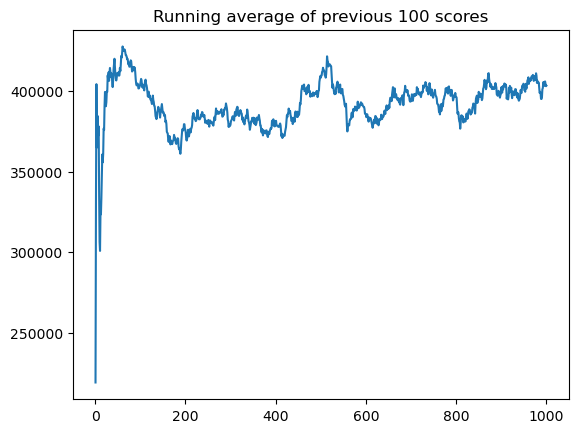

In [204]:
x = [i + 1 for i in range(len(score_history))]
plot_learning_curve(x, score_history)

In [167]:
state =  env.observation

In [176]:
action = agent.choose_action(env.observation)

In [178]:
action

array(5)

In [177]:
action / 10 * 2 * env.mc

30.0

In [171]:
state = torch.from_numpy(state).float()
_ , probs = agent.model(state)
action_dist = torch.distributions.Categorical(probs=probs)
action = action_dist.sample()



In [172]:
agent.model(state)

(tensor([-47.7459], grad_fn=<AddBackward0>),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward0>))

In [179]:
env.step(action)

TypeError: type numpy.ndarray doesn't define __round__ method

In [175]:
type(x)

int

In [180]:
observation = env.observe_state(env.date)

# get bid from action
bid_volume = env.capacity

# the bid price is relative to the marginal costs
bid_price = action / 10 * 2 * env.mc

profit, da_price = env.market_clearing(bid_price, bid_volume, env.date)

# scale the reward
reward = (profit / env.reward_scaling)

In [187]:
profi

array([11184.])

In [190]:
env.prices.loc[env.date]

85.92